In [1]:
from IPython.core.display import HTML
from IPython.lib.display import YouTubeVideo
from IPython.display import Image

def css_styling():
    styles = open("custom.css", "r").read()
    return HTML(styles)
css_styling()

from norm_functions import * # import all functions defined in the file norm_functions.py

import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy

# Expression signatures of Barrett's esophagus and esophageal adenocarcinoma
## Biol Sci 378, Winter 2022, Northwestern University
### Reese Richardson (rakr@u.northwestern.edu), Eric Weiss (elweiss@northwestern.edu) (group name: Evanston) 

<font color='red'> This example report should give you an example of what kind of analysis you could perform in your own report. It should **NOT** be used an exact guide.
</font>

For our project, we decided to analyze a dataset related to esophageal adenocarcinoma (EAC), [a cancer that begins in the glandular cells of the esophagus that is the sixth most common cause of cancer deaths worldwide](https://www.mayoclinic.org/diseases-conditions/esophageal-cancer/symptoms-causes/syc-20356084). EAC is often preceded by a non-malignant condition known as Barrett's esophagus, characterize by damage to the tissue lining of the esophagus. In the experiment that will be analyzing (under EBI-GXA [E-MTAB-4054](https://www.ebi.ac.uk/gxa/experiments/E-MTAB-4054/Experiment%20Design)), researchers collected esophageal tissue from patients diagnosed with:

* normal esophagus (NORM, 19 samples)
* non-dysplastic Barrett's esophagus (NDBE, 19 samples)
* Barrett's esophagus with low-grade dysplasia (LGD, 8 samples)
* esophageal adenocarcinoma (EAC, 17 samples)

and performed RNA-seq to measure gene expression. This dataset was original published by [Maag et al. (2017)](https://aacrjournals.org/mcr/article/15/11/1558/267246/Novel-Aberrations-Uncovered-in-Barrett-s-Esophagus). The cells below import this dataset from file.

In [2]:
counts = pd.read_csv('E-MTAB-4054-raw-counts.tsv', sep='\t')
design = pd.read_csv('E-MTAB-4054-experiment-design.tsv', sep='\t')
design = design[design['Analysed'] == 'Yes'].reset_index(drop=True)

design['labels'] = ['']*len(design)

# re-labeling
design.loc[(design[['Factor Value[disease]', 'Factor Value[disease staging]']].values == ["Barrett's esophagus", "non-dysplastic"]).all(axis=1), 'labels'] = 'NDBE'
design.loc[(design[['Factor Value[disease]', 'Factor Value[disease staging]']].values == ["Barrett's esophagus", "low-grade dysplasia"]).all(axis=1), 'labels'] = 'LGD'
design.loc[(design['Factor Value[disease]'].values == "esophageal adenocarcinoma"), 'labels'] = 'EAC'
design.loc[(design['Factor Value[disease]'].values == "normal"), 'labels'] = 'NORM'

design = design.sort_values('labels')
cols_to_norm = design['Run'].values
labels = design['labels'].values

# normalizing
counts_norm = counts.copy()
counts_norm = norm_tmm(counts_norm, columns_to_norm=cols_to_norm, ref_col=cols_to_norm[0])

# importing DE data and re-naming columns
de_df = pd.read_csv('E-MTAB-4054-query-results.tsv', sep='\t', header=3)
de_df.columns = ['Gene ID', 'Gene Name', 
 'LGD_vs_NORM_fc', 'LGD_vs_NORM_p', 
 'NDBE_vs_LGD_fc', 'NDBE_vs_LGD_p', 
 'NDBE_vs_NORM_fc', 'NDBE_vs_NORM_p', 
 'EAC_vs_LGD_fc', 'EAC_vs_LGD_p', 
 'EAC_vs_NDBE_fc', 'EAC_vs_NDBE_p', 
 'EAC_vs_NORM_fc', 'EAC_vs_NORM_p']

# Hierarchical clustering

As an initial exploration of our data, we decided to perform heirarchical clustering on the genes that vary the most between these four conditions (as validated by an one-way ANOVA). We selected the 2000 most variable genes (2000 genes with lowest p-value from one-way ANOVA) for heirarchical clustering.

In [3]:
counts_norm = counts.copy()

counts_norm = norm_tmm(counts_norm, columns_to_norm=cols_to_norm, ref_col=cols_to_norm[0])

a = counts_norm[cols_to_norm].values[:,labels == 'EAC']
b = counts_norm[cols_to_norm].values[:,labels == 'LGD']
c = counts_norm[cols_to_norm].values[:,labels == 'NDBE']
d = counts_norm[cols_to_norm].values[:,labels == 'NORM']
counts_norm['anova_p'] = scipy.stats.f_oneway(a.T, b.T, c.T, d.T).pvalue
counts_norm = counts_norm.dropna(subset=['anova_p'])
counts_norm['bonferroni_fwer'] = counts_norm['anova_p']*len(counts_norm['anova_p'])
counts_norm.loc[counts_norm['bonferroni_fwer'] > 1, 'bonferroni_fwer'] = 1.0
counts_norm['bh_fdr'] = counts_norm['anova_p']*len(counts_norm['anova_p'])/counts_norm['anova_p'].rank()
counts_norm.loc[counts_norm['bh_fdr'] > 1, 'bh_fdr'] = 1.0

Text(0.5, 1, 'Z-score')

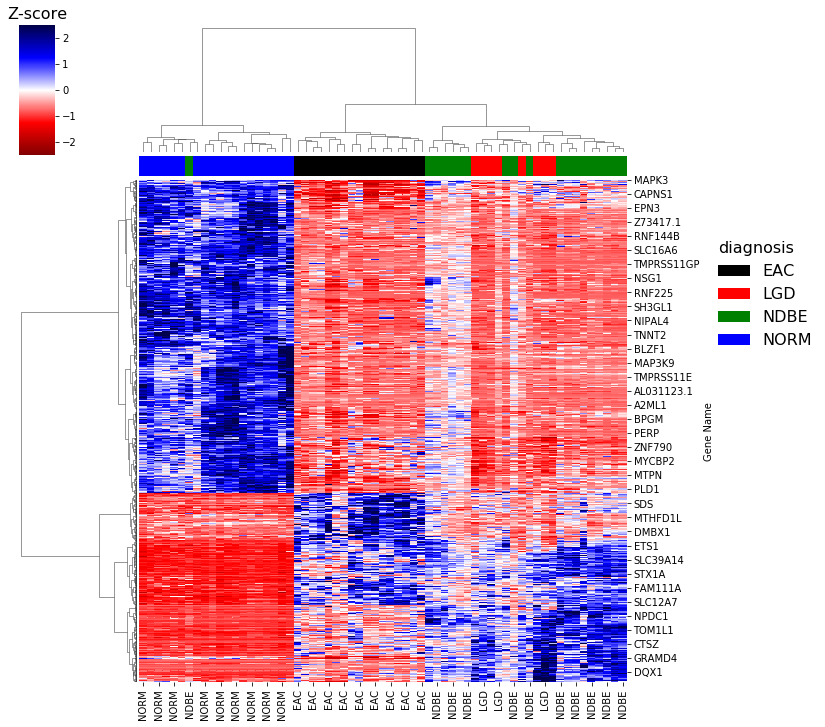

In [10]:
counts_norm_slim = counts_norm[counts_norm['bonferroni_fwer'].rank() <= 2000]
counts_norm_slim = counts_norm_slim.set_index('Gene Name')[cols_to_norm]
counts_norm_slim.columns = labels

# Define colors to label our columns to make the diagnosis categories of our clustermap easier to read
lut = dict(zip(np.unique(labels), ['k', 'r', 'g', 'b'])) # black, red, green, blue
col_colors = pd.DataFrame(labels)[0].map(lut)

g = sns.clustermap(counts_norm_slim, # data to cluster
                   method='ward', # method for heiarchical clustering
                   col_cluster=True, # cluster columns
                   z_score=0, # axis to perform z standardization
                   vmin=-2.5, vmax=2.5, # upper and lower limits of our colorbar
                   cmap='seismic_r', # palette to use for our colorbar
                   col_colors=[col_colors]) # what colors to label our columns on the margin

# define legend for col colors
ax = g.ax_heatmap
handles1 = [mpl.patches.Patch(facecolor=lut[name]) for name in lut]

leg1 = g.ax_row_dendrogram.legend(handles1, lut, title='diagnosis',
           bbox_to_anchor=(0.97, 0.70), bbox_transform=plt.gcf().transFigure, loc='upper left', frameon=False, fontsize=16)
plt.setp(leg1.get_title(),fontsize=16)
leg1._legend_box.align = "left"

g.ax_cbar.set_title(label='Z-score', fontsize=16)
#plt.savefig('EAC_clustermap.png', dpi=200, bbox_inches='tight')

A qualitative assessment of this clustermap suggests that the genes with significant alterations in expression between conditions organize into three large clusters: genes which are up-regulated in normal esophagus and down-regulated in Barrett's and EAC (cluster 0), genes that are uniquely up-regulated in EAC (cluster 1), and genes that are down-regulated in normal esophagus and up-regulated in Barrett's and EAC (cluster 2).

Sample-based clustering nearly perfectly sorts samples into one of three groups: normal esophagus, EAC, and non-malignant Barrett's esophagus. This comes with the exception of one NDBE sample clustered among the NORM samples, [which the authors of the original study using this expression data also noted](https://aacrjournals.org/mcr/article/15/11/1558/267246/Novel-Aberrations-Uncovered-in-Barrett-s-Esophagus).

We decided to perform over-representation analysis on the members of each of the three clusters returned by this clustering.

In [5]:
# re-performing heirarchical clustering
df_sliced_scaled = g.data2d
Z = scipy.cluster.hierarchy.ward(df_sliced_scaled)

# performing a tree cut at 3 clusters
tree_cut = np.ndarray.flatten(scipy.cluster.hierarchy.cut_tree(Z, n_clusters=3))

# exporting lists of genes in each cluster
for cluster_id in set(tree_cut):
    pd.DataFrame(df_sliced_scaled[tree_cut == cluster_id].index.values).to_csv('EAC_cluster_' + 
                                                                               str(cluster_id) + 
                                                                               '_gene_symbol.txt', 
                                                                               header=False, 
                                                                               index=False)

# exporting reference list of genes
pd.DataFrame(counts_norm['Gene Name'].values).to_csv('EAC_cluster_reference_gene_symbol.txt', header=False, index=False)

When we run WebGestalt on these clusters (using KEGG as a functional database), we find the following pathways are the most enriched for each cluster (highest enrichment ratio with FDR < 0.05):

#### Cluster 0:
1. [hsa00100: Steroid biosynthesis](https://www.kegg.jp/kegg-bin/show_pathway?hsa00100+1718+4047+50814+6307+6309+6713+7108)
2. [hsa04966: Collecting duct acid secretion](https://www.kegg.jp/kegg-bin/show_pathway?hsa04966+245973+50617+51382+523+529+9114+9296+9550)
3. [hsa04150: mTOR signaling pathway](https://www.kegg.jp/kegg-bin/show_pathway?hsa04150+11211+1975+1978+208+23175+245973+27330+3265+387+51382+51606+51719+523+529+54361+54468+55437+5563+5594+5595+5604+5605+58528+5894+6194+6199+6249+64121+7474+7477+7482+7483+80326+81029+8140+81617+8323+8649+89780+9296+9550)

#### Cluster 1:
1. [hsa03030: DNA replication](https://www.kegg.jp/kegg-bin/show_pathway?hsa03030+1763+2237+23649+4173+4175+5111+5422+5426+5427+5557+5558+5983+5984+79621)
2. [hsa03440: Homologous recombination](https://www.kegg.jp/kegg-bin/show_pathway?hsa03440+11073+146956+25788+472+51720+580+5889+5892+641+675+7516+79728+83990+8438)
3. [hsa05150: Staphylococcus aureus infection](https://www.kegg.jp/kegg-bin/show_pathway?hsa05150+2204+2209+2212+2214+2215+2357+2358+2359+3383+3684+629+6404+712+713+717+719+728)

#### Cluster 2:
1. [hsa00604: Glycosphingolipid biosynthesis](https://www.kegg.jp/kegg-bin/show_pathway?hsa00604+27090+2720+3074+6483+8869+9197)
2. [hsa00511: Other glycan degradation](https://www.kegg.jp/kegg-bin/show_pathway?hsa00511+23324+2517+2519+2720+3074+4126+57704)
3. [hsa00531: Glycosaminoglycan degradation](https://www.kegg.jp/kegg-bin/show_pathway?hsa00531+2720+2799+2990+3074+3373+4669+60495)

The enrichment of Cluster 1 for DNA-replication-related genes possiblyy reflects the increased rate cellular replication in cancer. [hsa04110: Cell cycle](https://www.kegg.jp/entry/pathway+hsa04110) is also enriched in this cluster, supporting this hypothesis. 

This raises the possibility of gene signatures that are unique to EAC in comparison to its non-malignant precursors. To probe this further, We constructed two groups of genes:
1. Genes that are uniquely up-regulated in EAC compared to its non-malignant precursors (FDR < 0.05 and log2FC > 0 for comparisons EAC vs NORM, EAC vs LGD, and EAC vs NDBE)
2. Genes that are uniquely down-regulated in EAC compared to its non-malignant precursors (FDR < 0.05 and log2FC < 0 for comparisons EAC vs NORM, EAC vs LGD, and EAC vs NDBE)

These sets are constructed in the cells below.

In [6]:
de_cond_lgd = de_df['EAC_vs_LGD_p'] <= 0.05
de_cond_ndbe = de_df['EAC_vs_NDBE_p'] <= 0.05
de_cond_norm = de_df['EAC_vs_NORM_p'] <= 0.05

up_cond_lgd = de_df['EAC_vs_LGD_fc'] > 0
up_cond_ndbe = de_df['EAC_vs_NDBE_fc'] > 0
up_cond_norm = de_df['EAC_vs_NORM_fc'] > 0

down_cond_lgd = de_df['EAC_vs_LGD_fc'] < 0
down_cond_ndbe = de_df['EAC_vs_NDBE_fc'] < 0
down_cond_norm = de_df['EAC_vs_NORM_fc'] < 0

eac_up_slice = de_df[de_cond_lgd & de_cond_ndbe & de_cond_norm & up_cond_norm & up_cond_ndbe & up_cond_lgd]
eac_down_slice = de_df[de_cond_lgd & de_cond_ndbe & de_cond_norm & down_cond_norm & down_cond_ndbe & down_cond_lgd]

In [7]:
# exporting gene name .txts
pd.DataFrame(eac_up_slice['Gene Name']).to_csv('EAC_unique_up_gene_symbol.txt', header=False, index=False)
pd.DataFrame(eac_down_slice['Gene Name']).to_csv('EAC_unique_down_gene_symbol.txt', header=False, index=False)

When performing over-representation analysis on these sets using the [Hallmark 50](https://pubmed.ncbi.nlm.nih.gov/26771021/) as a functional database (WebGestalt > Over-Representation Analysis > Functional Database > Community-Contributed > Hallmark50), we find the following Hallmark gene sets to be most enriched in each set (highest enrichment ratio with FDR < 0.05).

#### Uniquely up-regulated in EAC:
1. [cell cycle progression: E2F targets](https://www.gsea-msigdb.org/gsea/msigdb/cards/HALLMARK_E2F_TARGETS)
2. [cell cycle progression: G2/M checkpoint](https://www.gsea-msigdb.org/gsea/msigdb/cards/HALLMARK_G2M_CHECKPOINT)
3. [inflammatory response](https://www.gsea-msigdb.org/gsea/msigdb/cards/HALLMARK_INFLAMMATORY_RESPONSE)

#### Uniquely down-regulated in EAC:
1. [cholesterol homeostasis](https://www.gsea-msigdb.org/gsea/msigdb/cards/HALLMARK_CHOLESTEROL_HOMEOSTASIS)
2. [fatty acid metabolism](https://www.gsea-msigdb.org/gsea/msigdb/cards/HALLMARK_FATTY_ACID_METABOLISM)
3. [p53 pathway](https://www.gsea-msigdb.org/gsea/msigdb/cards/HALLMARK_P53_PATHWAY)

We were particularly interested in the enrichment of E2F targets among up-regulated genes in EAC, as members of the E2F family of transcription factors (members E2F1, E2F2 ... E2F8) are [known effectors of various cancers](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3616489/). This prompted us to survey our expression data for members of this family, where we found significant dysregulation unique to esophageal adenocarcinoma. For instance, the activators E2F1 and E2F3, as well as the repressors E2F5, E2F6 and E2F7, are uniquely up-regulated in EAC versus its non-malignant precursors. Expression of E2F1, E2F3, E2F5, E2F6, E2F7 is particularly high in a subset of EAC samples. See the table and clustermap in the cells below.

In [8]:
e2f_family = ['E2F1', 'E2F2', 'E2F3', 'E2F3', 'E2F4', 'E2F5', 'E2F6', 'E2F7', 'E2F8']
de_df[de_df['Gene Name'].isin(e2f_family)][['Gene Name', 'EAC_vs_LGD_fc', 'EAC_vs_LGD_p', 'EAC_vs_NDBE_fc', 'EAC_vs_NDBE_p',
       'EAC_vs_NORM_fc', 'EAC_vs_NORM_p']].sort_values('Gene Name')

,Gene Name,EAC_vs_LGD_fc,EAC_vs_LGD_p,EAC_vs_NDBE_fc,EAC_vs_NDBE_p,EAC_vs_NORM_fc,EAC_vs_NORM_p
2514,E2F1,1.2,0.009220,1.7,0.000002,1.6,8.539747e-10
196,E2F2,-0.8,0.012805,-0.6,0.112724,-1.4,7.528456e-16
4014,E2F3,0.9,0.007221,1.0,0.000014,1.3,1.940636e-11
19142,E2F4,-0.3,0.244433,0.2,0.637335,0.3,1.909130e-01
6747,E2F5,0.8,0.022642,0.7,0.016283,1.3,2.389630e-08
12403,E2F6,1.1,0.001892,0.8,0.002807,1.1,9.241022e-08
11630,E2F7,1.3,0.001823,1.3,0.000009,0.9,1.432014e-04
6087,E2F8,0.6,0.228874,0.8,0.105999,0.8,1.498788e-02


Text(0.5, 1, 'Z-score')

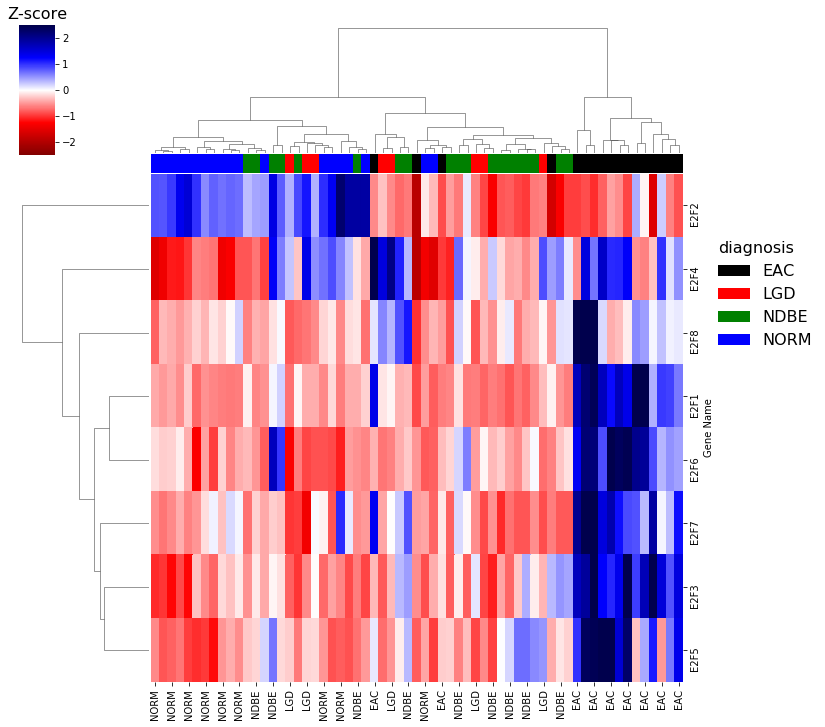

In [9]:
e2f_family = ['E2F1', 'E2F2', 'E2F3', 'E2F3', 'E2F4', 'E2F5', 'E2F6', 'E2F7', 'E2F8']
counts_norm_slim = counts_norm[counts_norm['Gene Name'].isin(e2f_family)]

counts_norm_slim = counts_norm_slim.set_index('Gene Name')[cols_to_norm]
counts_norm_slim.columns = labels

# Define colors to label our columns to make the diagnosis categories of our clustermap easier to read
lut = dict(zip(np.unique(labels), ['k', 'r', 'g', 'b'])) # black, red, green, blue
col_colors = pd.DataFrame(labels)[0].map(lut)

g = sns.clustermap(counts_norm_slim, # data to cluster
                   method='ward', # method for heiarchical clustering
                   col_cluster=True, # cluster columns
                   z_score=0, # axis to perform z standardization
                   vmin=-2.5, vmax=2.5, # upper and lower limits of our colorbar
                   cmap='seismic_r', # palette to use for our colorbar
                   col_colors=[col_colors]) # what colors to label our columns on the margin

# define legend for col colors
ax = g.ax_heatmap
handles1 = [mpl.patches.Patch(facecolor=lut[name]) for name in lut]

leg1 = g.ax_row_dendrogram.legend(handles1, lut, title='diagnosis',
           bbox_to_anchor=(0.97, 0.70), bbox_transform=plt.gcf().transFigure, loc='upper left', frameon=False, fontsize=16)
plt.setp(leg1.get_title(),fontsize=16)
leg1._legend_box.align = "left"

g.ax_cbar.set_title(label='Z-score', fontsize=16)
#plt.savefig('EAC_clustermap.png', dpi=200, bbox_inches='tight')

Although members of the E2F family have previously been identified as biomarkers of other cancers of the gastrointenstinal tract ([Ebihara et al.](https://pubmed.ncbi.nlm.nih.gov/15230729/) and [Chen et al.](https://pubmed.ncbi.nlm.nih.gov/35116590/)), links between the E2F family and EAC have yet to be made with much specificity. The dysregulation of E2F family members and targets thereof in EAC lead us to believe that the E2F family may lead a key role in the development of EAC that could be exploited for therapeutic purposes.

## Group member contributions:
RAKR wrote the sections of code performing clustering and cleaned the final notebook. ELW performed ORA with WebGestalt and conducted background research on genes of interest.

<font color='red'> Just because we stopped here doesn't mean that you should! We encourage you to push your dataset as far as you can with as diverse a set of methods as you feel comfortable.
</font>